In [1]:
import pickle
import pandas as pd
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl

with open('dataset/filtered_df.pkl', 'rb') as f:
    df = pickle.load(f)  
df

,Employment_Status,Annual_Income,Credit_Score,Outstanding_Debt,Loan_Amount_Requested,Loan_Type,Loan_Approval_Status
0,Employed,139901,743,19822,24535,Secured,1
1,Employed,21162,468,18321,8288,Unsecured,0
4,Employed,81753,752,8780,23360,Unsecured,1
8,Self-Employed,121626,803,13940,20239,Secured,0
10,Self-Employed,54670,772,22104,20000,Unsecured,1
...,...,...,...,...,...,...,...
51986,Self-Employed,105630,734,14841,26616,Unsecured,1
51989,Unemployed,118085,714,9803,30183,Secured,0
51990,Self-Employed,134581,756,15172,24717,Unsecured,1
51992,Unemployed,34019,572,19031,8383,Unsecured,0


/Users/brageramberg/opt/miniconda3/envs/INF264/lib/python3.8/site-packages/skfuzzy/control/fuzzyvariable.py:125: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


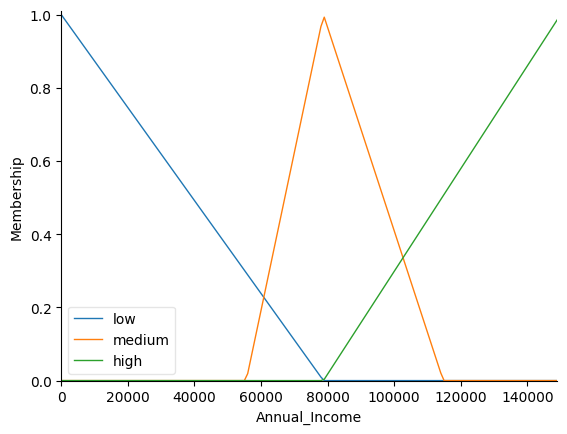

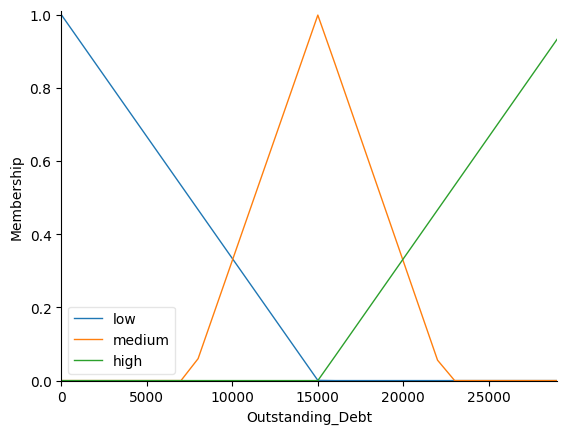

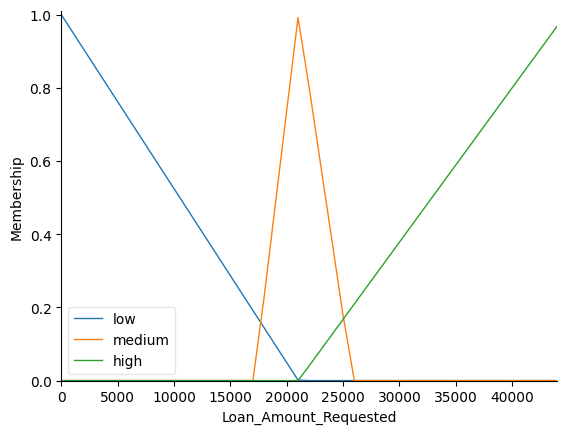

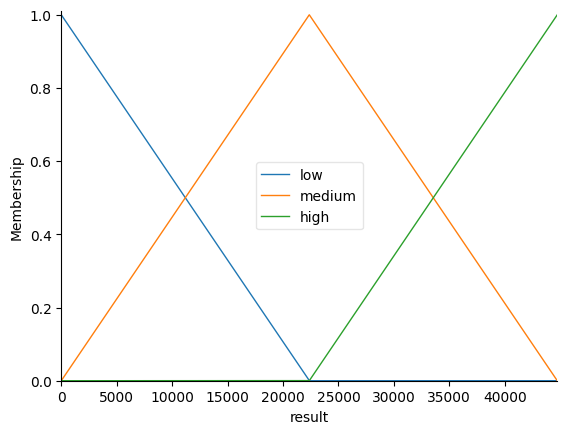

In [2]:
# Calculating the max, min, and average of 'Annual_income' column
max_income = df['Annual_Income'].max()
max_loan = df['Loan_Amount_Requested'].max()
max_outstanding_debt = df['Outstanding_Debt'].max()

def custom_fuzzification(antecedent, data, column_name):
    """
    Sets up 'low', 'medium', and 'high' fuzzy membership functions for a given column in the data.
    
    Parameters:
    - antecedent: The fuzzy antecedent to apply the memberships to (e.g., annual_income).
    - data: The DataFrame containing the data.
    - column_name: The column name to base the membership functions on.
    """
    # Calculate cutoffs dynamically
    low_cutoff = data[column_name].quantile(0.5)
    medium_cutoff_start = data[column_name].quantile(0.25)
    medium_cutoff_middle = data[column_name].quantile(0.5)
    medium_cutoff_end = data[column_name].quantile(0.75)
    max_income_end = data[column_name].max()
    
    # Define triangular membership functions
    antecedent['low'] = fuzz.trimf(antecedent.universe, [0, 0, low_cutoff])
    antecedent['medium'] = fuzz.trimf(antecedent.universe, [medium_cutoff_start, medium_cutoff_middle, medium_cutoff_end])
    antecedent['high'] = fuzz.trimf(antecedent.universe, [medium_cutoff_middle, max_income_end, max_income_end])

# Custom fuzzification function
annual_income = ctrl.Antecedent(np.arange(0, max_income + 1, 1000), 'Annual_Income')
loan_amount_requested = ctrl.Antecedent(np.arange(0, max_loan + 1, 1000), 'Loan_Amount_Requested')
outstanding_debt = ctrl.Antecedent(np.arange(0, max_outstanding_debt + 1, 1000), 'Outstanding_Debt')
result = ctrl.Consequent(np.arange(0, max_loan + 1, 1), 'result')


# maybe average later or not
result = ctrl.Consequent(np.arange(0, max_loan+1, 1), 'result')
result['low'] = fuzz.trimf(result.universe, [0, 0, max_loan/2])
result['medium'] = fuzz.trimf(result.universe, [0, max_loan/2, max_loan])
result['high'] = fuzz.trimf(result.universe, [max_loan/2, max_loan, max_loan])


# Apply the custom fuzzification function
custom_fuzzification(annual_income, df, "Annual_Income")
custom_fuzzification(loan_amount_requested, df, "Loan_Amount_Requested")
custom_fuzzification(outstanding_debt, df, "Outstanding_Debt")

annual_income.view()
outstanding_debt.view()
loan_amount_requested.view()
result.view()

In [3]:
# Rule 1: Low income and low debt result in a low loan amount
rule1 = ctrl.Rule(annual_income['low'] & outstanding_debt['low'], result['low'])

# Rule 2: Medium income and low debt result in a medium loan amount
rule2 = ctrl.Rule(annual_income['medium'], result['medium'])

# Rule 3: High income and low debt result in a high loan amount
rule3 = ctrl.Rule(annual_income['high'] & outstanding_debt['low'], result['high'])



# # Rule 1: Low income and low debt result in a low loan amount
# rule1 = ctrl.Rule(annual_income['low'] & outstanding_debt['low'], result['low'])

# # Rule 2: Medium income and low debt result in a medium loan amount
# rule2 = ctrl.Rule(annual_income['medium'] & outstanding_debt['low'], result['medium'])

# # Rule 3: High income and low debt result in a high loan amount
# rule3 = ctrl.Rule(annual_income['high'] & outstanding_debt['low'], result['high'])

# # Rule 4: Low income and medium debt result in a low loan amount
# rule4 = ctrl.Rule(annual_income['low'] & outstanding_debt['medium'], result['low'])

# # Rule 5: Medium income and medium debt result in a medium loan amount
# rule5 = ctrl.Rule(annual_income['medium'] & outstanding_debt['medium'], result['medium'])

# # Rule 6: High income and medium debt result in a high loan amount
# rule6 = ctrl.Rule(annual_income['high'] & outstanding_debt['medium'], result['high'])

# # Rule 7: Low income and high debt result in a low loan amount
# rule7 = ctrl.Rule(annual_income['low'] & outstanding_debt['high'], result['low'])

# # Rule 8: Medium income and high debt result in a medium loan amount
# rule8 = ctrl.Rule(annual_income['medium'] & outstanding_debt['high'], result['low'])

# # Rule 9: High income and high debt result in a high loan amount
# rule9 = ctrl.Rule(annual_income['high'] & outstanding_debt['high'], result['medium'])

In [4]:
def get_fuzzy_sets_and_results(df):
    """
    Returns the fuzzy sets and their corresponding results for 'Annual_Income', 
    'Loan_Amount_Requested', 'Outstanding_Debt', and 'result' (loan category).
    
    Parameters:
    - df: The dataframe containing the data to base the fuzzy sets on.
    
    Returns:
    - annual_income, loan_amount_requested, outstanding_debt, result: The fuzzy sets and results.
    """
    # Calculate max values from the data
    max_income = df['Annual_Income'].max()
    max_loan = df['Loan_Amount_Requested'].max()
    max_outstanding_debt = df['Outstanding_Debt'].max()

    # Create fuzzy sets for each column
    annual_income = ctrl.Antecedent(np.arange(0, max_income + 1, 1000), 'Annual_Income')
    loan_amount_requested = ctrl.Antecedent(np.arange(0, max_loan + 1, 1000), 'Loan_Amount_Requested')
    outstanding_debt = ctrl.Antecedent(np.arange(0, max_outstanding_debt + 1, 1000), 'Outstanding_Debt')
    result = ctrl.Consequent(np.arange(0, max_loan + 1, 1), 'result')

    # Apply custom fuzzification (fuzzify the columns based on quantiles)
    custom_fuzzification(annual_income, df, "Annual_Income")
    custom_fuzzification(loan_amount_requested, df, "Loan_Amount_Requested")
    custom_fuzzification(outstanding_debt, df, "Outstanding_Debt")

    # Define fuzzy result categories
    result['low'] = fuzz.trimf(result.universe, [0, 0, max_loan/2])
    result['medium'] = fuzz.trimf(result.universe, [0, max_loan/2, max_loan])
    result['high'] = fuzz.trimf(result.universe, [max_loan/2, max_loan, max_loan])

    # Return all fuzzy sets and the result categories
    return annual_income, loan_amount_requested, outstanding_debt, result

In [ ]:
# Function to calculate the categorical result for a single row
def calculate_categorical_result(row, annual_income, outstanding_debt):
    # Inputs from the dataset
    income = row['Annual_Income']
    debt = row['Outstanding_Debt']
    
    # Fuzzify inputs using existing membership functions
    income_low_level = fuzz.interp_membership(annual_income.universe, annual_income['low'].mf, income)
    income_medium_level = fuzz.interp_membership(annual_income.universe, annual_income['medium'].mf, income)
    income_high_level = fuzz.interp_membership(annual_income.universe, annual_income['high'].mf, income)
    
    debt_low_level = fuzz.interp_membership(outstanding_debt.universe, outstanding_debt['low'].mf, debt)
    
    # Check if all membership levels are zero (no activation)
    if income_low_level == 0 and income_medium_level == 0 and income_high_level == 0 and debt_low_level == 0:
        return None  # Return None for rows with no activation

    # Apply rules to get the activation strength for each result
    rule1_activation = np.fmin(income_low_level, debt_low_level)  # Rule 1: low result
    rule2_activation = income_medium_level  # Rule 2: medium result
    rule3_activation = np.fmin(income_high_level, debt_low_level)  # Rule 3: high result
    
    # Store rule activations in a dictionary
    rule_strengths = {
        'low': rule1_activation,
        'medium': rule2_activation,
        'high': rule3_activation
    }
    
    # Determine the result with the highest activation strength
    result_category = max(rule_strengths, key=rule_strengths.get)
    return result_category

# # Apply the function to calculate results for the entire dataset
# df['Fuzzy_Category_Result'] = df.apply(calculate_categorical_result, axis=1)

# # Display the dataset with fuzzy results
# print(df.head())